# Diabetes Progression - Can we find a predictive model?
## Multiple Linear Regression - Ridge Regression
### Cody B February 19, 2025

The goal of this analysis is to determine if it's possible to generate a multi-variable regression model to predict diabetes disease progression. Ten variables, age, sex, body mass index, average blood pressure, and six blood serum measurements, will be used to predict a quantitative meausre of diabetes progression. The dataset used for this analysis is available through Scikit-Learn and can be found here: sklearn.datasets.load_diabetes(). This dataset was originally desribed by Efron, Bradley, et al. in "Least Angle Regression", <https://hastie.su.domains/Papers/LARS/LeastAngle_2002.pdf>.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns

In [2]:
df = sk.datasets.load_diabetes(as_frame=True)
X = df.data
y = df.target

X # Exploratory data analysis

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930


As shown, the dataset consists of 442 samples, with each sample having 10 features. Bmi refers to Body Mass Index and Bp refers to average blood pressure. The blood serum features will be described later.

Additionally, it's clear that the data for the 10 features has already been normalized. Specifically, the documentation states that the data has been mean centered and scaled by the standard deviation.

In [3]:
X = X.rename(columns={"s1":"tc","s2":"ldl","s3":"hdl","s4":"tch","s5":"ltg","s6":"glu"}) # Renaming blood serum columns for readability

tc = Total serum cholesterol

ldl = Low-density lipoproteins

hdl = High-density lipoproteins

tch = Total cholesterol / HDL

ltg = Possibly log of serum triglycerides level

glu = Blood sugar level

In [4]:
# Dictionary of {Attribute : R-Squared}
r_squared_scores = {}

# Data processing
target = y.to_numpy()
target = target.reshape(-1,1)

# For each feature column, reshape feature data, perform univariate linear regression with ordinary least squares, and calculate the R-squared score
for column in X:
    feature = X[column].to_numpy()
    feature = feature.reshape(-1,1)
    reg = sk.linear_model.LinearRegression()
    reg.fit(feature,target)
    target_predict = reg.predict(feature)
    r_squared_scores[column] = sk.metrics.r2_score(target,target_predict)

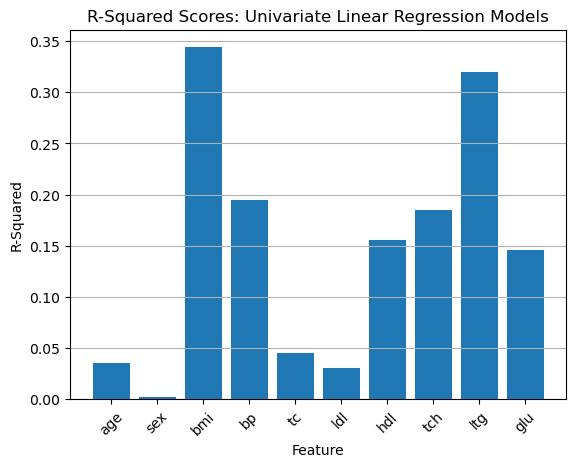

In [5]:
# Plot each feature and its R-squared score
fig,ax = plt.subplots()
ax.bar(x=r_squared_scores.keys(), height=r_squared_scores.values())
ax.set_title("R-Squared Scores: Univariate Linear Regression Models")
ax.set_ylabel("R-Squared")
ax.set_xlabel("Feature")
ax.grid(True,"major","y")
ax.tick_params("x",rotation=45)
plt.show()

As shown, Body Mass Index (bmi) and log of serum triglycerides level (itg) had the highest R-squared scores, meaning these two features explain more variation of diabetes disease progression than the other features. Other notable features include average blood pressure (bp), high-density lipoproteins (hdl), total cholesterol / HDL (tch), and blood sugar levels.

It's possible that some of these features exhibit collinearity, and this is addressed below. 

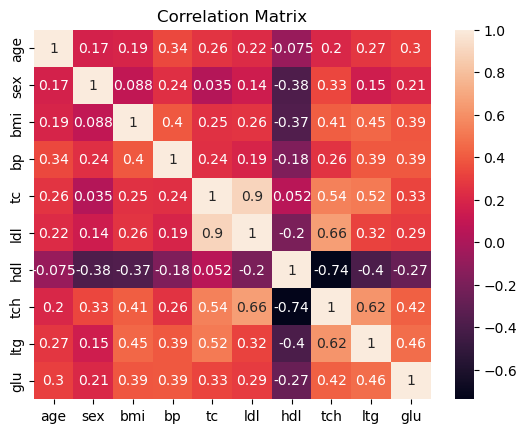

In [6]:
# Plot correlation matrix of features in the dataset
_, ax = plt.subplots()
ax.set_title("Correlation Matrix")
ax = sns.heatmap(X.corr(),annot=True)
plt.show()

A correlation matrix of the features was produced to explore if there was collinearity. As can be seen, ldl and tc are highly correlated. This won't severely affect the modeling however as both tc and ldl aren't meaningful to diabetes disease progression. Numerous other feature pairs exhibit mild correlation as well, which adds to the fact that causation will probably be impossible to infer from the modeling. Additionally, this might suggest that this dataset is a good candidate for Principal Component Analysis (PCA). PCA on this dataset could produce a more robust and predictive model.

In [7]:
# Data processing
feature = X.to_numpy()
target = y.to_numpy().reshape(-1,1)
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(feature,target,test_size=0.25,random_state=0)

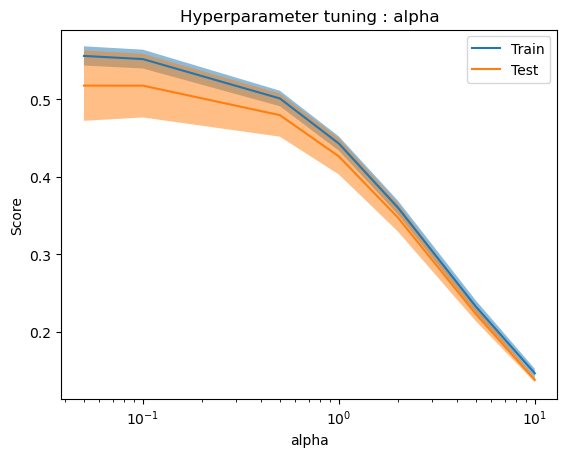

In [8]:
# Plot hypeparameter tuning
_, ax = plt.subplots()
sk.model_selection.ValidationCurveDisplay.from_estimator(sk.linear_model.Ridge(),X_train,y_train,ax=ax,param_name="alpha",param_range=[0.05,0.1,0.5,1.0,2.0,5.0,10.0])
ax.set_title("Hyperparameter tuning : alpha")
plt.show()

To develop the regression, the alpha hyperparameter was tuned. As shown, the model score began to plateau at an alpha of around ~0.1, thus, an alpha of 0.1 was used in subsequent analyses.

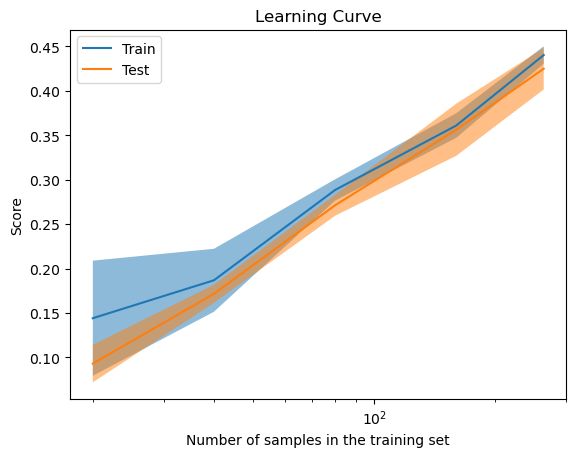

In [9]:
# Plot learning curve
_, ax = plt.subplots()
sk.model_selection.LearningCurveDisplay.from_estimator(sk.linear_model.Ridge(),X_train,y_train,ax=ax,train_sizes=[20,40,80,160,264])
ax.set_title("Learning Curve")
plt.show()

A learning curve was produced to explore if the model could benefit from more training samples. As shown by the train score and test score increasing with increasing number of samples in the training set, this model would probably benefit from more training samples. 

In [10]:
# Model with fewer training samples
ridge = sk.linear_model.Ridge(alpha=0.1,random_state=42)
ridge.fit(X_train,y_train)
print(f"Training samples: {len(X_train)}, Coefficient of determination: {ridge.score(X_test,y_test)}")

# Redo the train_test_split with smaller proportion of test_size in order to increase training size
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(feature,target,test_size=0.1,random_state=45)

# Model with more training samples
ridge = sk.linear_model.Ridge(alpha=0.1,random_state=42)
ridge.fit(X_train,y_train)
print(f"Training samples: {len(X_train)}, Coefficient of determination: {ridge.score(X_test,y_test)}")

Training samples: 331, Coefficient of determination: 0.3690250543749982
Training samples: 397, Coefficient of determination: 0.5485520525169316


The model benefitting from more training samples is also shown above. Note how the model with 397 training samples outperformed the model with only 331 training samples. 

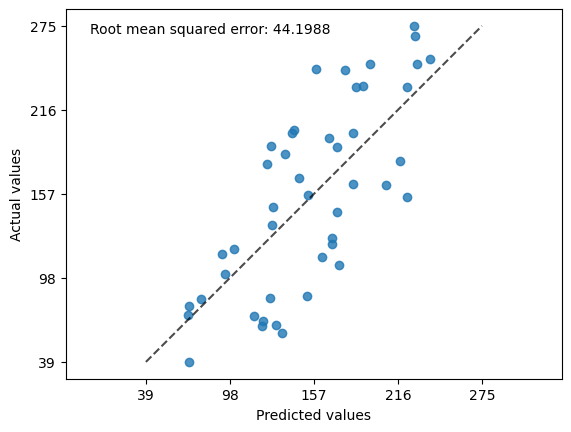

In [11]:
y_predict = ridge.predict(X_test)

rmse = round(sk.metrics.root_mean_squared_error(y_test,y_predict),4)
textStr = f"Root mean squared error: {rmse}"

fig, ax = plt.subplots()
sk.metrics.PredictionErrorDisplay.from_predictions(y_test,y_predict,ax=ax,kind="actual_vs_predicted")
ax.text(0,270,textStr)
plt.show()

Based on the above prediction error display and root mean sqaured error, the model is ok at predicting diabetes disease progression. The model used for the above was the model trained on the higher number of training samples, and this model had an R-squared of 0.55. Based on the display, the model doesn't appear to have high bias, but it does appear to have high variance. An increase in dataset size would likely reduce this, especially considering the learning curve that was discussed.

### Conclusions
- Model decently predicts diabetes disease progression from the 10 features.
- On average, the model will be off by 44 units, and the model will explain 55% of the variance of diabetes disease progression.
- More training samples would benefit the model.
- Future work might inclulde Principal Component Analysis since some of the features exhibit collinearity.
- Future work might include implementing other regression models, like Lasso.